# Описание задачи

Набор данных разделен на 2 папки (train, test) и содержит подпапки для каждой категории изображений (пневмония/нормальное состояние). Всего 5 857 рентгеновских снимка (JPEG) и 2 категории (`PNEUMONIA`/`NORMAL`).

Рентгеновские снимки грудной клетки (передне-задние) были отобраны из ретроспективных когорт педиатрических пациентов в возрасте от одного до пяти лет из медицинского центра Guangzhou Women and Children, Гуанчжоу. Все рентгеновские снимки грудной клетки были выполнены в рамках рутинного клинического наблюдения за пациентами.

Для анализа рентгеновских снимков грудной клетки все рентгенограммы грудной клетки были первоначально проверены на предмет контроля качества путем удаления всех некачественных или нечитаемых снимков.

# Загрузка необходимых библиотек

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, utils, datasets
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
%matplotlib inline

# Обработка данных

Определяем пути к папкам с обучающей и тестовой выборками

In [182]:
data_dir = 'D:\учеба\pneumonia\ChestXRay2017\chest_xray'
train_class_path = os.listdir(data_dir + '/train')
test_class_path = os.listdir(data_dir + '/test')
classes = ['NORMAL', 'PNEUMONIA']

Преобразовываем данные к единому размеру, чтобы модель могла с ними корректно работать, а также добавляем искажения, чтобы модель видела разные вариации данных, училась находить закономерности на разнородных данных.

Затем загружаем данные при помощи DataLoader.

In [22]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(data_dir + '/test', transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

Визуализируем изображения, с которыми будем работать

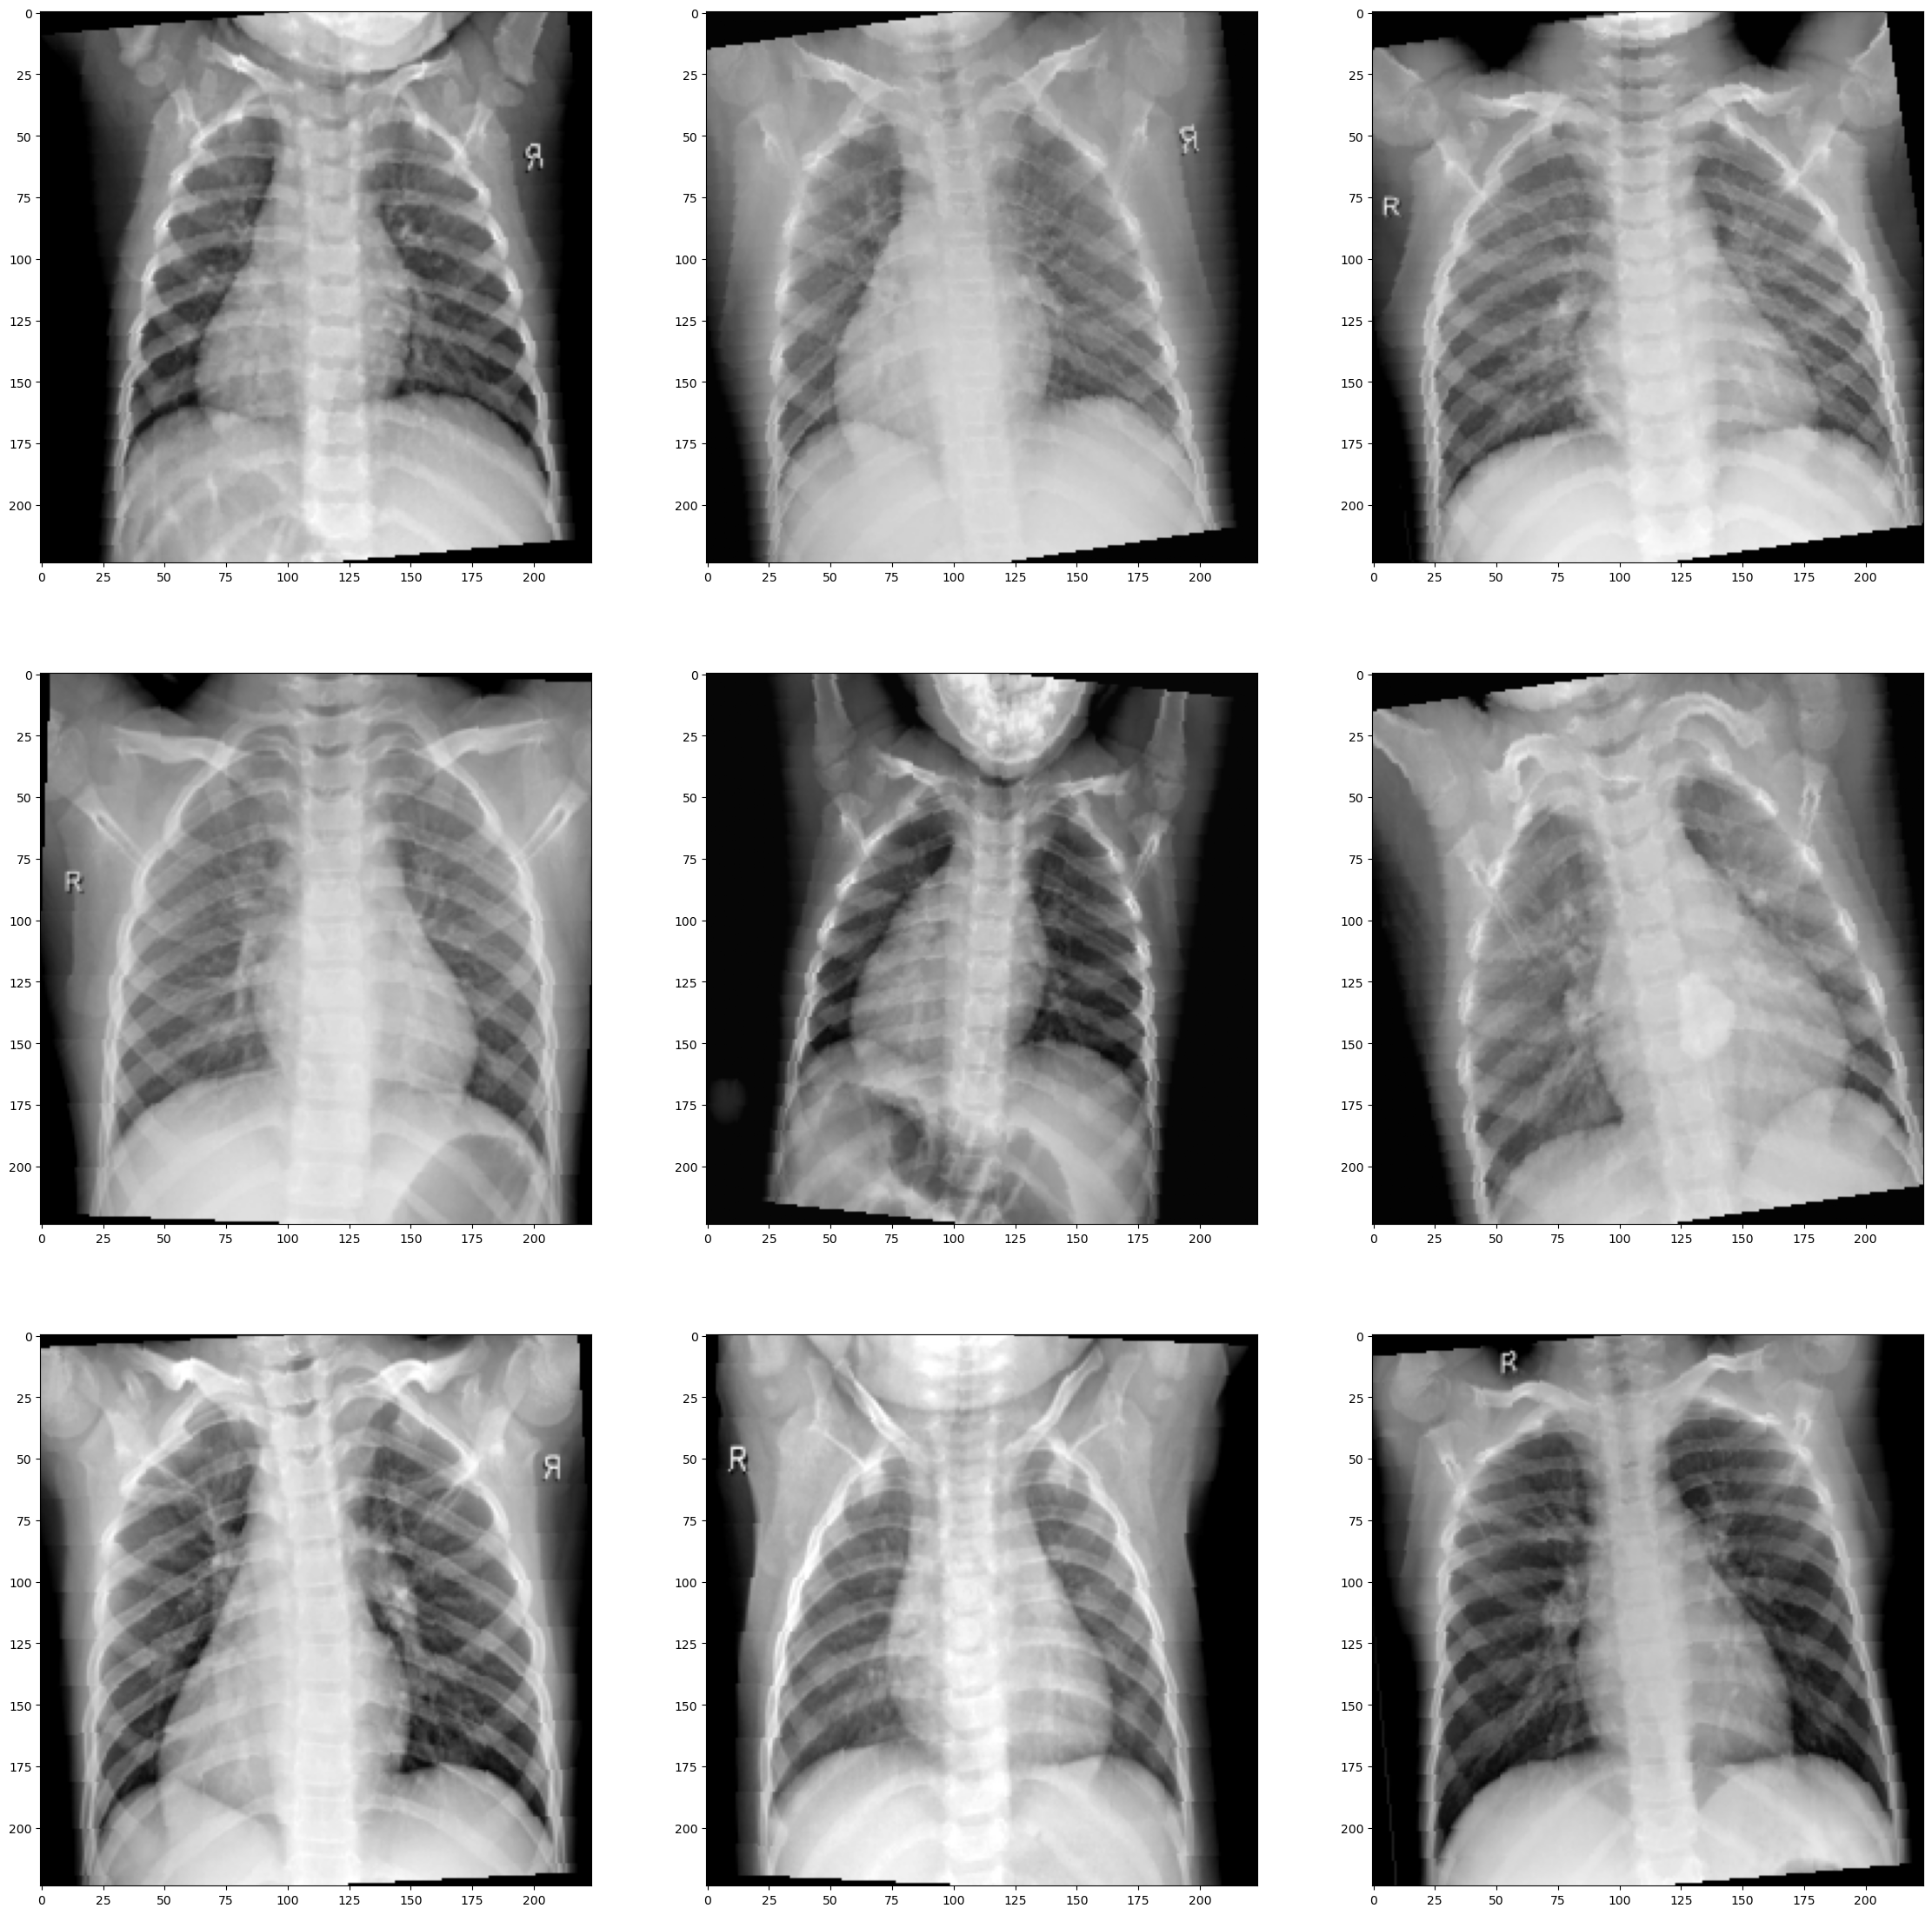

In [43]:
plt.figure(figsize=(28, 28))
for i in range(9):
    img = train_dataset[i][0]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

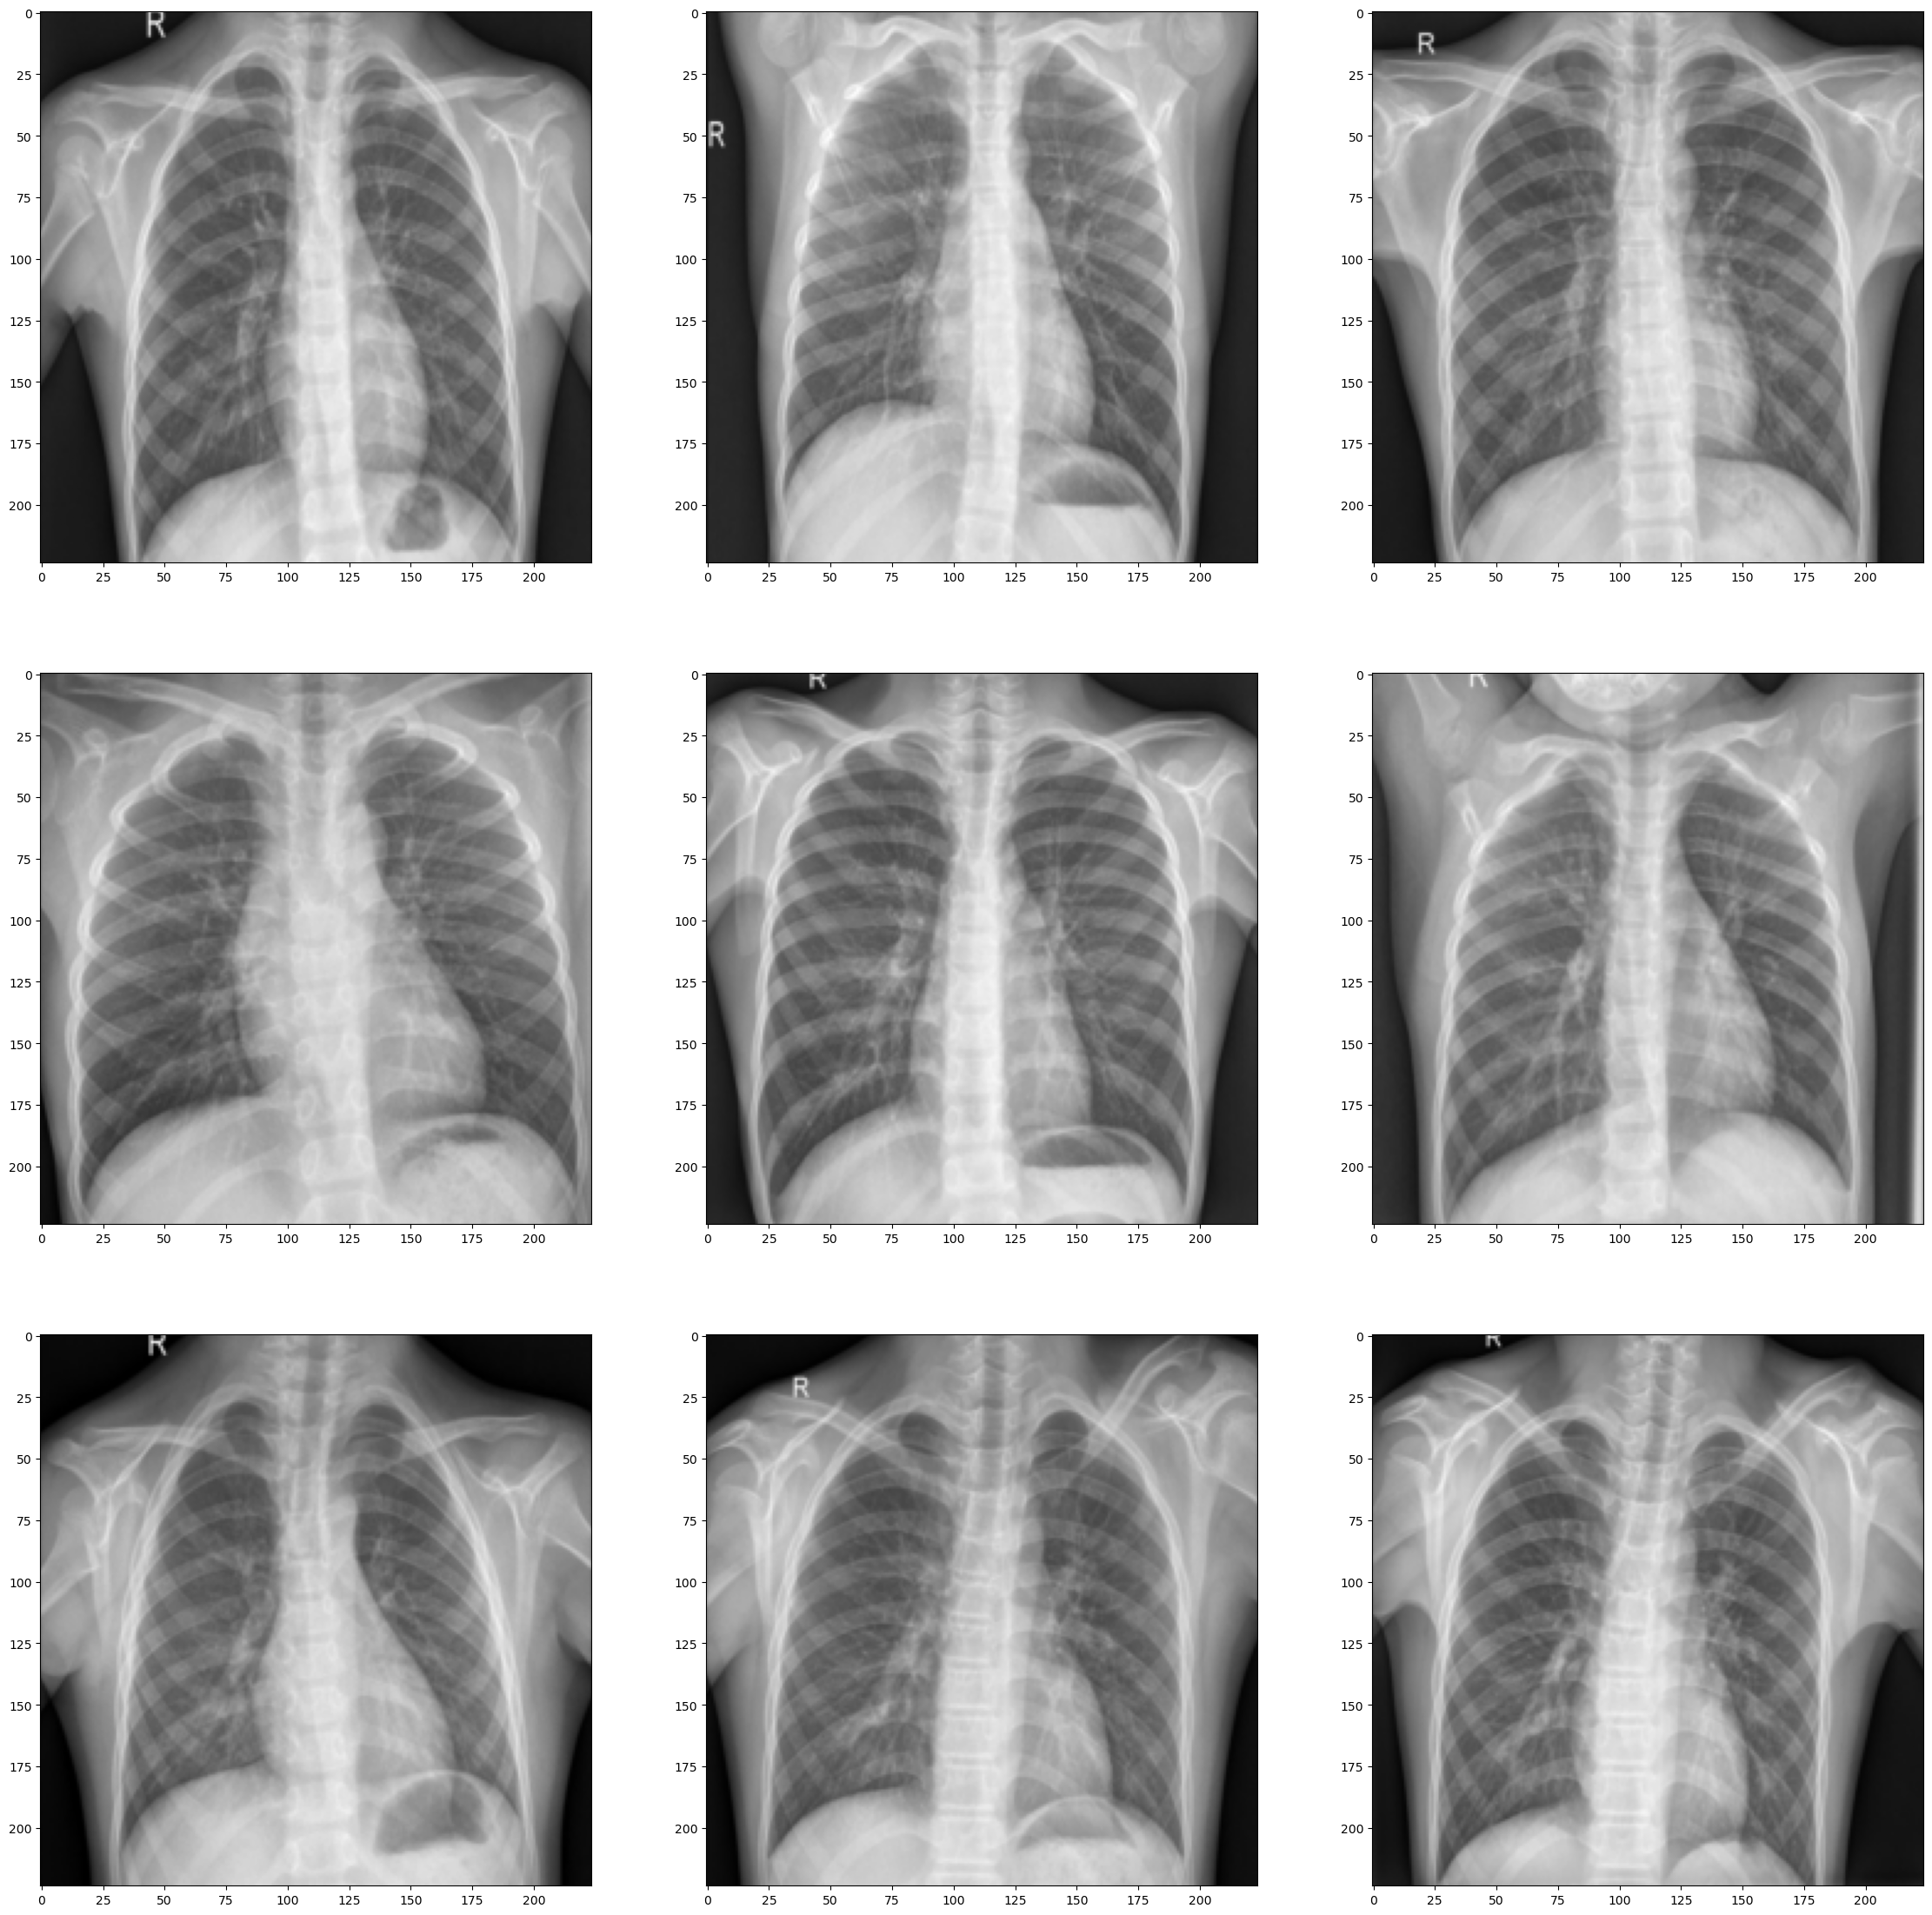

In [44]:
plt.figure(figsize=(28, 28))
for i in range(9):
    img = test_dataset[i][0]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

Переносим данные на GPU, чтобы ускорить обучение.

Будем пользоваться предобученной моделью resnet18.

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True) 

Меняем последний слой, так как на выходе хотим получить 2 признака - принадлежность к классу `NORMAL` или `PNEUMONIA`. К тому же добавляем отключение части нейронов, что позволит эффективнее бороться с переобучением.

In [48]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.5), 
    nn.Linear(model.fc.in_features, 2))
model = model.to(device)

Замораживаем все слои, кроме трех последних, чтобы сохранить часть уже обученных весов.

In [50]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.avgpool.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# Обучение на resnet18

In [32]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_losses = []
    accuracies = []

    def calc_metrics(lab, pred):
        lab = lab.cpu()
        pred = pred.cpu()
        sk_accuracy = accuracy_score(lab,pred)
        sk_precision = precision_score(lab,pred,average='weighted')
        sk_recall = recall_score(lab,pred,average='weighted')
        sk_f1_score = f1_score(lab,pred,average='weighted')
        return sk_accuracy, sk_precision, sk_recall, sk_f1_score

    sk_f1_scores, sk_accuracies, sk_recalls, sk_precisions=[],[],[],[]
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_sk_f1_score, epoch_sk_accuracy, epoch_sk_recall, epoch_sk_precision = 0,0,0,0
        
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device) 
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            running_loss += loss
            preds_arg = outputs.argmax(dim=1)
            sk_f1_score, sk_accuracy, sk_recall, sk_precision=calc_metrics(labels, preds_arg)

            epoch_sk_f1_score+=sk_f1_score
            epoch_sk_accuracy += sk_accuracy
            epoch_sk_recall += sk_recall
            epoch_sk_precision += sk_precision
            
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        epoch_sk_f1_score = epoch_sk_f1_score / len(train_dataloader)
        epoch_sk_accuracy = epoch_sk_accuracy/ len(train_dataloader)
        epoch_sk_recall = epoch_sk_recall / len(train_dataloader)
        epoch_sk_precision = epoch_sk_precision / len(train_dataloader)

        sk_f1_scores.append(epoch_sk_f1_score)
        sk_accuracies.append(epoch_sk_accuracy)
        sk_recalls.append(epoch_sk_recall)
        sk_precisions.append(epoch_sk_precision)
        
        model.eval()
        test_loss = 0.0
        correct = 0
        test_epoch_sk_f1_score, test_epoch_sk_accuracy, test_epoch_sk_recall, test_epoch_sk_precision = 0,0,0,0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss
                
                preds_arg = outputs.argmax(dim=1)
                correct += (preds_arg == labels).float().mean()

                test_sk_f1_score, test_sk_accuracy, test_sk_recall, test_sk_precision=calc_metrics(labels, preds_arg)
                test_epoch_sk_f1_score+=test_sk_f1_score
                test_epoch_sk_accuracy += test_sk_accuracy
                test_epoch_sk_recall += test_sk_recall
                test_epoch_sk_precision += test_sk_precision
            
        test_epoch_loss = test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        accuracy = correct / len(test_dataloader)
        accuracies.append(accuracy)

        test_epoch_sk_f1_score = test_epoch_sk_f1_score / len(test_dataloader)
        test_epoch_sk_accuracy = test_epoch_sk_accuracy/ len(test_dataloader)
        test_epoch_sk_recall = test_epoch_sk_recall / len(test_dataloader)
        test_epoch_sk_precision = test_epoch_sk_precision / len(test_dataloader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        metrics = {'train': {'sk_accuracy': epoch_sk_accuracy, 'loss':epoch_loss, 'sk_f1_score':epoch_sk_f1_score, 
                             'sk_recall': epoch_sk_recall, 
                             'sk_precision': epoch_sk_precision},
                  'test': {'accuracy': accuracy, 'sk_accuracy': test_epoch_sk_accuracy, 'loss':test_epoch_loss, 'sk_f1_score':test_epoch_sk_f1_score,
                           'sk_recall': test_epoch_sk_recall, 
                            'sk_precision': test_epoch_sk_precision}}
    
    return train_losses, test_losses, accuracies, metrics, sk_f1_scores, sk_accuracies, sk_recalls, sk_precisions

In [40]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [55]:
num_epochs = 3
train_losses, test_losses, accuracies, metrics, sk_f1_scores, sk_accuracies, sk_recalls, sk_precisions = train_model(
    model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs
)

Epoch 1/3:
Train Loss: 0.3008, Test Loss: 0.2041, Accuracy: 0.9281
Epoch 2/3:
Train Loss: 0.1711, Test Loss: 0.2054, Accuracy: 0.9269
Epoch 3/3:
Train Loss: 0.1275, Test Loss: 0.1951, Accuracy: 0.9338


In [57]:
metrics

{'train': {'sk_accuracy': 0.9641924696729882,
  'loss': tensor(0.1275, device='cuda:0', grad_fn=<DivBackward0>),
  'sk_f1_score': 0.9563084112149524,
  'sk_recall': 0.9563084112149524,
  'sk_precision': 0.9573765345771817},
 'test': {'accuracy': tensor(0.9338, device='cuda:0'),
  'sk_accuracy': 0.9989423076923076,
  'loss': tensor(0.1951, device='cuda:0'),
  'sk_f1_score': 0.9337500000000002,
  'sk_recall': 0.9337500000000002,
  'sk_precision': 0.9574131651503166}}

In [169]:
data = {
    'train': {
        'sk_accuracy': 0.9641924696729882,
        'loss': 0.1275,
        'sk_f1_score': 0.9563084112149524,
        'sk_recall': 0.9563084112149524,
        'sk_precision': 0.9573765345771817
    },
    'test': {
        'accuracy': 0.9338,
        'sk_accuracy': 0.9989423076923076,
        'loss': 0.1951,
        'sk_f1_score': 0.9337500000000002,
        'sk_recall': 0.9337500000000002,
        'sk_precision': 0.9574131651503166
    }
}

df = pd.DataFrame(data).T

# Переименовываем метрики для красоты
df.index = ['Train', 'Test']
metric_names = {
    'sk_accuracy': 'sk_Accuracy',
    'loss': 'Loss',
    'sk_f1_score': 'F1 Score',
    'sk_recall': 'Recall',
    'sk_precision': 'Precision',
    'accuracy': 'Accuracy'
}
df = df.rename(columns=metric_names)
display(df)

sk_Accuracy    Loss  F1 Score    Recall  Precision  Accuracy
Train     0.964192  0.1275  0.956308  0.956308   0.957377       NaN
Test      0.998942  0.1951  0.933750  0.933750   0.957413    0.9338

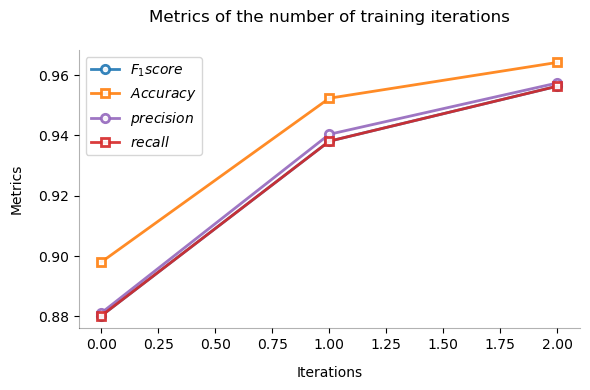

In [147]:
iterations = np.arange(0, 3)

plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(iterations, sk_f1_scores, 'o-', color='#1f77b4', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2,
        label='$F_1 score$', alpha=0.9)

ax.plot(iterations, sk_accuracies, 's-', color='#ff7f0e', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2, 
        label='$Accuracy$', alpha=0.9)

ax.plot(iterations, sk_precisions, 'o-', color='#9467bd', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2,
        label='$precision$', alpha=0.9)

ax.plot(iterations, sk_recalls, 's-', color='#d62728',  linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2, 
        label='$recall$', alpha=0.9)

ax.set_xlabel('Iterations', fontsize=10, labelpad=10)
ax.set_ylabel('Metrics', fontsize=10,  labelpad=10)
ax.set_title('Metrics of the number of training iterations', 
             fontsize=12,  pad=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.3)
plt.legend()
plt.tight_layout()
plt.show()

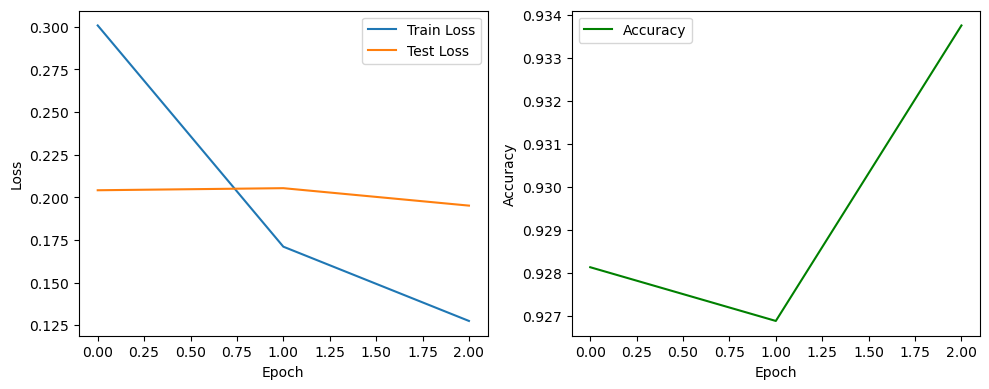

In [171]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot([tensor.item() for tensor in train_losses], label='Train Loss')
plt.plot([tensor.item() for tensor in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([tensor.item() for tensor in accuracies], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Обучение с помощью сверточной нейросети

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
           
        )
        self.fc1 = nn.Linear(64*28*28, 10000)
        self.fc2 = nn.Linear(10000, 800)
        self.fc3 = nn.Linear(800, 2)

    def forward(self, X):
        X = self.convs(X)
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [26]:
def train_CNN(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_losses = []
    accuracies = []

    def calc_metrics(lab, pred):
        lab = lab.cpu()
        pred = pred.cpu()
        sk_accuracy = accuracy_score(lab,pred)
        sk_precision = precision_score(lab,pred,average='weighted')
        sk_recall = recall_score(lab,pred,average='weighted')
        sk_f1_score = f1_score(lab,pred,average='weighted')
        return sk_accuracy, sk_precision, sk_recall, sk_f1_score

    sk_f1_scores, sk_accuracies, sk_recalls, sk_precisions=[],[],[],[]
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_sk_f1_score, epoch_sk_accuracy, epoch_sk_recall, epoch_sk_precision = 0,0,0,0
        
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            running_loss += loss
            preds_arg = outputs.argmax(dim=1)
            sk_f1_score, sk_accuracy, sk_recall, sk_precision=calc_metrics(labels, preds_arg)

            epoch_sk_f1_score+=sk_f1_score
            epoch_sk_accuracy += sk_accuracy
            epoch_sk_recall += sk_recall
            epoch_sk_precision += sk_precision
            
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        epoch_sk_f1_score = epoch_sk_f1_score / len(train_dataloader)
        epoch_sk_accuracy = epoch_sk_accuracy/ len(train_dataloader)
        epoch_sk_recall = epoch_sk_recall / len(train_dataloader)
        epoch_sk_precision = epoch_sk_precision / len(train_dataloader)

        sk_f1_scores.append(epoch_sk_f1_score)
        sk_accuracies.append(epoch_sk_accuracy)
        sk_recalls.append(epoch_sk_recall)
        sk_precisions.append(epoch_sk_precision)
        
        model.eval()
        test_loss = 0.0
        correct = 0
        test_epoch_sk_f1_score, test_epoch_sk_accuracy, test_epoch_sk_recall, test_epoch_sk_precision = 0,0,0,0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss
                
                preds_arg = outputs.argmax(dim=1)
                correct += (preds_arg == labels).float().mean()

                test_sk_f1_score, test_sk_accuracy, test_sk_recall, test_sk_precision=calc_metrics(labels, preds_arg)
                test_epoch_sk_f1_score+=test_sk_f1_score
                test_epoch_sk_accuracy += test_sk_accuracy
                test_epoch_sk_recall += test_sk_recall
                test_epoch_sk_precision += test_sk_precision
            
        test_epoch_loss = test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        accuracy = correct / len(test_dataloader)
        accuracies.append(accuracy)

        test_epoch_sk_f1_score = test_epoch_sk_f1_score / len(test_dataloader)
        test_epoch_sk_accuracy = test_epoch_sk_accuracy/ len(test_dataloader)
        test_epoch_sk_recall = test_epoch_sk_recall / len(test_dataloader)
        test_epoch_sk_precision = test_epoch_sk_precision / len(test_dataloader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        metrics = {'train': {'sk_accuracy': epoch_sk_accuracy, 'loss':epoch_loss, 'sk_f1_score':epoch_sk_f1_score, 
                             'sk_recall': epoch_sk_recall, 
                             'sk_precision': epoch_sk_precision},
                  'test': {'accuracy': accuracy, 'sk_accuracy': test_epoch_sk_accuracy, 'loss':test_epoch_loss, 'sk_f1_score':test_epoch_sk_f1_score,
                           'sk_recall': test_epoch_sk_recall, 
                            'sk_precision': test_epoch_sk_precision}}
    
    return train_losses, test_losses, accuracies, metrics, sk_f1_scores, sk_accuracies, sk_recalls, sk_precisions

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
model = CNN().to(device)

In [42]:
num_epochs = 5
train_losses_CNN, test_losses_CNN, accuracies_CNN, metrics_CNN, sk_f1_scores_CNN, sk_accuracies_CNN, sk_recalls_CNN, sk_precisions_CNN = train_model(
    model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs
)

Epoch 1/5:
Train Loss: 0.5150, Test Loss: 0.4300, Accuracy: 0.8031
Epoch 2/5:
Train Loss: 0.2228, Test Loss: 0.4864, Accuracy: 0.7859
Epoch 3/5:
Train Loss: 0.1680, Test Loss: 0.5850, Accuracy: 0.7734
Epoch 4/5:
Train Loss: 0.1524, Test Loss: 0.4883, Accuracy: 0.8047
Epoch 5/5:
Train Loss: 0.1392, Test Loss: 0.6405, Accuracy: 0.7672


In [43]:
metrics_CNN

{'train': {'sk_accuracy': 0.9543816356057794,
  'loss': tensor(0.1392, device='cuda:0', grad_fn=<DivBackward0>),
  'sk_f1_score': 0.9477099236641213,
  'sk_recall': 0.9477099236641213,
  'sk_precision': 0.9470933310966804},
 'test': {'accuracy': tensor(0.7672, device='cuda:0'),
  'sk_accuracy': 0.9939338235294117,
  'loss': tensor(0.6405, device='cuda:0'),
  'sk_f1_score': 0.7671874999999999,
  'sk_recall': 0.7671874999999999,
  'sk_precision': 0.823033978195196}}

In [46]:
data = {
    'train': {
        'sk_accuracy': 0.9543816356057794,
        'loss': 0.1392,
        'sk_f1_score': 0.9477099236641213,
        'sk_recall': 0.9477099236641213,
        'sk_precision': 0.9470933310966804
    },
    'test': {
        'accuracy': 0.7672,
        'sk_accuracy': 0.993933823529411,
        'loss': 0.6405,
        'sk_f1_score': 0.7671874999999999,
        'sk_recall': 0.7671874999999999,
        'sk_precision': 0.823033978195196
    }
}

df = pd.DataFrame(data).T

# Переименовываем метрики для красоты
df.index = ['Train', 'Test']
metric_names = {
    'sk_accuracy': 'sk_Accuracy',
    'loss': 'Loss',
    'sk_f1_score': 'F1 Score',
    'sk_recall': 'Recall',
    'sk_precision': 'Precision',
    'accuracy': 'Accuracy'
}
df = df.rename(columns=metric_names)
display(df)

sk_Accuracy    Loss  F1 Score    Recall  Precision  Accuracy
Train     0.954382  0.1392  0.947710  0.947710   0.947093       NaN
Test      0.993934  0.6405  0.767187  0.767187   0.823034    0.7672

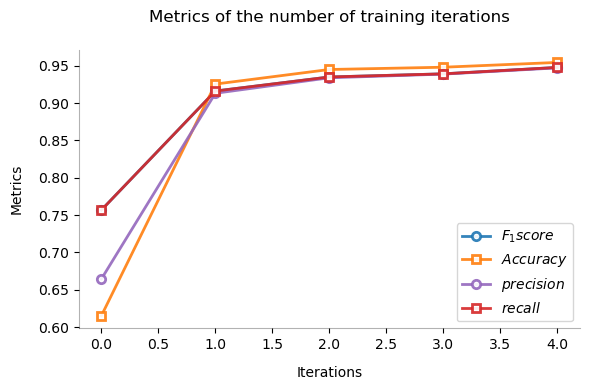

In [48]:
iterations = np.arange(0, 5)

plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(iterations, sk_f1_scores_CNN, 'o-', color='#1f77b4', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2,
        label='$F_1 score$', alpha=0.9)

ax.plot(iterations, sk_accuracies_CNN, 's-', color='#ff7f0e', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2, 
        label='$Accuracy$', alpha=0.9)

ax.plot(iterations, sk_precisions_CNN, 'o-', color='#9467bd', linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2,
        label='$precision$', alpha=0.9)

ax.plot(iterations, sk_recalls_CNN, 's-', color='#d62728',  linewidth=2, 
        markersize=6, markerfacecolor='white', markeredgewidth=2, 
        label='$recall$', alpha=0.9)

ax.set_xlabel('Iterations', fontsize=10, labelpad=10)
ax.set_ylabel('Metrics', fontsize=10,  labelpad=10)
ax.set_title('Metrics of the number of training iterations', 
             fontsize=12,  pad=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.3)
plt.legend()
plt.tight_layout()
plt.show()

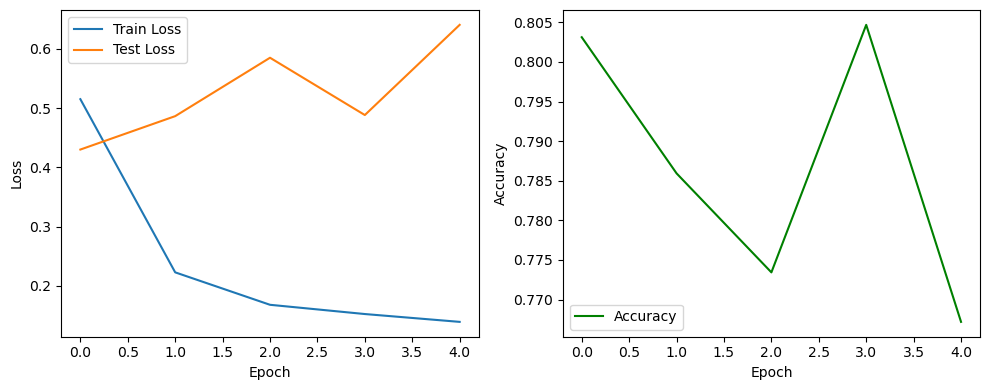

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot([tensor.item() for tensor in train_losses_CNN], label='Train Loss')
plt.plot([tensor.item() for tensor in test_losses_CNN], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([tensor.item() for tensor in accuracies_CNN], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод и сравнение архитектур.

Провели обучение, используя две архитектуры: предобученную resnet18 и CNN с тремя сверточными и тремя полносвязными слоями. Получив результаты, видим что resnet18 значительно превосходит сверточную нейросеть по всем метрикам. Она демонстрирует высокую точность, показатели метрик, незначительное переобучение - всего 3%, в то время как сверточная сеть наоборот показывает низкую точность на тестовой выборке и сильно переобучается. К тому же, ее обучение занимает намного больше времени, поэтому хотя сверточную сеть можно попробовать доработать (поэкспериментировать с регуляризацией, уменьшить количество нейронов), но нужно иметь более мощное обородувание для этого.